In [1]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml


# Loading data for cases

In [2]:
def get_dirs(base_path):
    return [os.path.join(base_path, d) for d in next(os.walk(base_path))[1]]

def load_yaml(path):
    with open(path, encoding="utf-8") as f:
        return yaml.safe_load(f)

def load_model_data_to_dict(base_path):
    return {
        "confusion_matrix_validation": np.load(os.path.join(base_path, "Callbacks", "epoch_end_confusion_matrix.npy")),
        "f_weighted_validation": np.load(os.path.join(base_path, "Callbacks", "epoch_end_f1_weighted.npy")),
        "metrics": pd.read_csv(os.path.join(base_path, "Metrics_and_losses.csv"), index_col=None),
        "config": load_yaml(os.path.join(base_path, "config.yaml")),
        "x_train": np.load(os.path.join(base_path, "Data/x_train.npy")),
        "y_train": np.load(os.path.join(base_path, "Data/y_train.npy")),
        "x_validation": np.load(os.path.join(base_path, "Data/x_validation.npy")),
        "y_validation": np.load(os.path.join(base_path, "Data/y_validation.npy")),
        "x_test": np.load(os.path.join(base_path, "Data/x_test.npy")),
        "y_test": np.load(os.path.join(base_path, "Data/y_test.npy")),
        
    }


In [4]:
path_dir_cnn = os.path.join("Models", "Final", "CNN")
path_dir_cdt = os.path.join("Models", "Final", "CDT_1D")

if not os.path.exists("tmp_cnn_result.pickle") or False:
    case_dirs_cnn = {
        os.path.basename(d): {
            model_path: load_model_data_to_dict(model_path) for model_path in get_dirs(d)
        } for d in get_dirs(path_dir_cnn)
    }

    with open("tmp_cnn_result.pickle", "wb") as f:
        pickle.dump(case_dirs_cnn, f)
else:
    with open("tmp_cnn_result.pickle", "rb") as f:
        case_dirs_cnn = pickle.loads(f.read())

if not os.path.exists("tmp_cdt_result.pickle") or False:
    case_dirs_cdt = {
        os.path.basename(d): {
            model_path: load_model_data_to_dict(model_path) for model_path in get_dirs(d)
        } for d in get_dirs(path_dir_cdt)
    }

    with open("tmp_cdt_result.pickle", "wb") as f:
        pickle.dump(case_dirs_cdt, f)
else:
    with open("tmp_cdt_result.pickle", "rb") as f:
        case_dirs_cdt = pickle.loads(f.read())


# Plots

In [31]:
def plot_metric_by_one_case(dataset, metric, model = "cnn", metric_extra = None, title = "Trajektoria metryki."):
    _case_dirs = case_dirs_cnn if model == "cnn" else case_dirs_cdt
    _case_dirs = _case_dirs[dataset]
    if metric_extra is None:
        _case_dirs = {
            k: {
                "data": _case_dirs[k][metric],
                "config": _case_dirs[k]["config"],
            } for k in _case_dirs.keys()
        }
    else:
        _case_dirs = {
            k: {
                "data": _case_dirs[k][metric][metric_extra].values,
                "config": _case_dirs[k]["config"],
            } for k in _case_dirs.keys()
        }

    for k in _case_dirs.keys():
        d = _case_dirs[k]
        t = json.dumps(d["config"], sort_keys=True, indent=2)
        y = d["data"]
        x = range(1, len(y)+1)


        fig = plt.figure(figsize=(10, 8))
        fig.suptitle(title)


        ax = fig.add_subplot()
        x_tics = np.arange(0, len(x) + 11, 5)
        ax.set_xticks(x_tics)
        ax.set_xticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(x_tics)])
        ax.set_xlabel("Numer epoki")

        ax.set_ylim(0, 1)
        y_tics = np.arange(0, 1.05, 0.05)
        ax.set_yticks(y_tics)
        ax.set_yticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(y_tics)])
        ax.set_ylabel("Wartość metryki")

        ax.grid(axis="both")
        ax.plot(x, y)

        fig.text(1.01, 0, t, ha='left', wrap=False)

        fig.tight_layout()
        fig.subplots_adjust(top=0.9)
        
        if metric_extra is None:
            path_to_save = os.path.join("tmp_plots", model, dataset, metric, "_".join(k.split(os.sep)) + ".png")
        else:
            path_to_save = os.path.join("tmp_plots", model, dataset, metric_extra, "_".join(k.split(os.sep)) + ".png")
        os.makedirs(os.path.dirname(path_to_save), exist_ok=True)
        fig.savefig(path_to_save, bbox_inches='tight')

        plt.close()



In [ ]:
for ds in case_dirs_cnn.keys():
    plot_metric_by_one_case(ds, "f_weighted_validation", model="cnn", metric_extra=None,
                            title="Trajektoria wartości metryki F ważonej dla zbioru walidacyjnego,\nw procesie trenowania modelu.")

for ds in case_dirs_cnn.keys():
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="val_loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cnn", metric_extra="val_f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )


In [34]:
for ds in case_dirs_cdt.keys():
    plot_metric_by_one_case(ds, "f_weighted_validation", model="cdt", metric_extra=None,
                            title="Trajektoria wartości metryki F ważonej dla zbioru walidacyjnego,\nw procesie trenowania modelu.")

for ds in case_dirs_cdt.keys():
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="val_loss",
    title="Trajektoria wartości funkcji kary kategorycznej entropii krzyżowej dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru treningowego,\nw procesie trenowania modelu."
    )
    plot_metric_by_one_case(ds, "metrics", model="cdt", metric_extra="val_f1_m",
    title="Trajektoria wartości metryki F1 dla zbioru walidacyjnego,\nw procesie trenowania modelu."
    )


# Brudnopis

In [5]:
_case_dirs = case_dirs_cnn
_case_dirs = _case_dirs["all"]
_case_dirs = {
    k: {
        "data": _case_dirs[k]["f_weighted_validation"],
        "config": _case_dirs[k]["config"],
    } for k in _case_dirs.keys()
}
_case_dirs

{'Models/Final/CNN/all/2023-06-12_09-52-53_0': {'data': array([0.2792243 , 0.53173132, 0.59634082, 0.38950122, 0.56609433,
         0.40985977, 0.09150914, 0.37942854, 0.56389061, 0.53141497,
         0.46610029, 0.49143835, 0.44159928, 0.52521953, 0.36333102,
         0.51545072, 0.42052703, 0.31660886, 0.50894467, 0.52698838,
         0.50749235, 0.42372971, 0.61804639, 0.5528921 , 0.51503838,
         0.52200416, 0.51262596, 0.48488804, 0.4983419 , 0.51277762,
         0.42577397, 0.51768526, 0.44121834, 0.48359283, 0.49928492,
         0.57991846, 0.44514308, 0.51938364, 0.5030359 , 0.56104927,
         0.49644259, 0.48974064, 0.53642012, 0.55961618, 0.4989949 ,
         0.46538694, 0.42591796, 0.50796985, 0.52432437, 0.50786138,
         0.49791493, 0.49234434, 0.46449666, 0.5403003 , 0.52505536,
         0.47131171, 0.52056062, 0.4734498 , 0.55020292, 0.47349341,
         0.53569136, 0.49548682, 0.51099174, 0.51384981, 0.50261953,
         0.49840568, 0.50240238, 0.49329801, 0.50

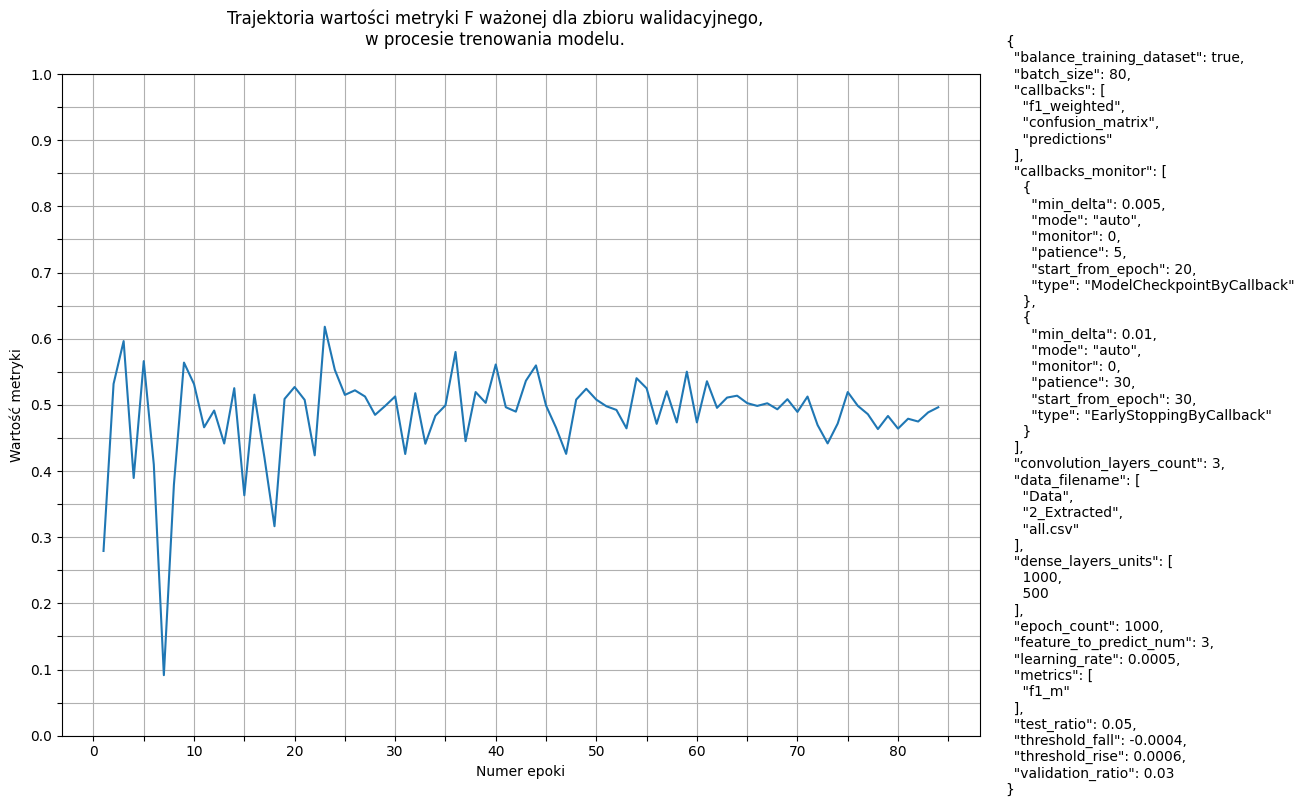

In [7]:
d = _case_dirs[list(_case_dirs.keys())[0]]
t = json.dumps(d["config"], sort_keys=True, indent=2)
y = d["data"]
x = range(1, len(y)+1)


fig = plt.figure(figsize=(10, 8))
fig.suptitle("Trajektoria wartości metryki F ważonej dla zbioru walidacyjnego,\n"
             "w procesie trenowania modelu.")


ax = fig.add_subplot()
x_tics = np.arange(0, len(x) + 11, 5)
ax.set_xticks(x_tics)
ax.set_xticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(x_tics)])
ax.set_xlabel("Numer epoki")

ax.set_ylim(0, 1)
y_tics = np.arange(0, 1.05, 0.05)
ax.set_yticks(y_tics)
ax.set_yticklabels([round(t, 2) if i%2==0 else "" for i, t in enumerate(y_tics)])
ax.set_ylabel("Wartość metryki")

ax.grid(axis="both")

ax.plot(x, y)

fig.text(1.01, 0, t, ha='left', wrap=False)

fig.tight_layout()
fig.subplots_adjust(top=0.9)



In [36]:
plt.close()

In [99]:

np.arange(0, 3, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9])

In [142]:
os.sep

'/'